In [4]:
import numpy as np
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from scipy import stats
import scipy.stats
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from sklearn import metrics
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False

In [2]:
ds_hmeq = pd.read_csv('./Downloads/week4day1/HMEQ.csv',encoding='CP949',engine='python')
ds_hmeq.head()
#타겟이 이산형

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [3]:
ds_hmeq.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [5]:
ds_hmeq["JOB"].fillna("Other", inplace=True)
#아예 비면 빠지므로 아더 입력
ds_hmeq.fillna(ds_hmeq.mean(), inplace=True)
#연속형 데이터에 평균값 입력

In [6]:
np.random.seed(seed=1234)
msk=np.random.rand(ds_hmeq.shape[0],)<0.7
ds_hmeq_train=ds_hmeq[msk]
ds_hmeq_test=ds_hmeq[~msk]

print("train data size: {}".format(ds_hmeq_train.shape))
print("test data size: {}".format(ds_hmeq_test.shape))

train data size: (2604, 13)
test data size: (1144, 13)


In [7]:
ds_hmeq_train=sm.add_constant(ds_hmeq_train)
ds_hmeq_train.head()

,const,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1.0,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,1.0,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
5,1.0,0,2900,103949,112505.0,HomeImp,Office,1.0,0,0.0,96.102330,0.0,13,30.051136
6,1.0,0,2900,104373,120702.0,HomeImp,Office,2.0,0,0.0,101.540297,0.0,13,29.915859


In [10]:
log_model=sm.Logit.from_formula("BAD~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) \
                                + YOJ + DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC + 1",
                                ds_hmeq_train)
log_result=log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.244454
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2604
Model:                          Logit   Df Residuals:                     2587
Method:                           MLE   Df Model:                           16
Date:                Thu, 31 Jan 2019   Pseudo R-squ.:                  0.2096
Time:                        16:56:58   Log-Likelihood:                -636.56
converged:                       True   LL-Null:                       -805.35
                                        LLR p-value:                 4.004e-62
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.7741      0.518     -9.209      0.000      -5.790      -3.758

In [13]:
y_pred=log_result.predict(ds_hmeq_test)
y_pred_class=(y_pred>0.5).astype(int)
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int64

In [14]:
print("Accuracy: {0:.3f}".format(metrics.accuracy_score(ds_hmeq_test["BAD"],y_pred_class)))

Accuracy: 0.924


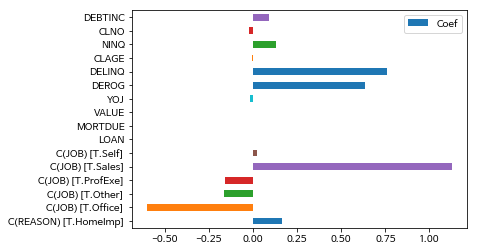

In [15]:
ds_logistic_coef=pd.DataFrame({"Coef":log_result.params.values[1:]}, index=log_model.exog_names[1:])
ds_logistic_coef.plot.barh(y="Coef")

In [16]:
ds_hmeq_char=ds_hmeq.select_dtypes(include="object")
ds_hmeq_numeric=ds_hmeq.select_dtypes(exclude="object")

ds_hmeq_char_train=ds_hmeq_char[msk]
ds_hmeq_numeric_scaled_train=scale(ds_hmeq_numeric[msk])
ds_hmeq_numeric_scaled_train=pd.DataFrame(ds_hmeq_numeric_scaled_train,columns=ds_hmeq_numeric.columns)
ds_hmeq_numeric_scaled_train.head()

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,3.124153,-1.546445,-0.994709,-1.227453,-0.020546,-0.26517,-0.337599,-0.962571,-0.019984,-1.424138,0.372555
1,3.124153,-1.537818,-1.040082,-1.177823,0.250021,-0.26517,-0.337599,-1.117329,-0.663021,-1.424138,0.344145
2,-0.320087,-1.494683,0.598052,0.247041,-0.967531,-0.26517,-0.337599,-1.090197,-0.663021,-0.898712,-0.313747
3,-0.320087,-1.442920,0.633069,0.092557,-1.102815,-0.26517,-0.337599,-1.027931,-0.663021,-0.898712,-0.504711
4,-0.320087,-1.442920,0.642472,0.242451,-0.967531,-0.26517,-0.337599,-0.961666,-0.663021,-0.898712,-0.521514


In [20]:
ds_hmeq_numeric_scaled_train["BAD"]=np.where(ds_hmeq_numeric_scaled_train["BAD"]>0,1,0)
ds_hmeq_numeric_scaled_train.head()

ds_hmeq_scaled_train=pd.concat([ds_hmeq_numeric_scaled_train, ds_hmeq_char_train.reset_index(drop=True)], axis=1)
ds_hmeq_scaled_train

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.546445,-0.994709,-1.227453,-0.020546,-0.265170,-0.337599,-0.962571,-0.019984,-1.424138,0.372555,HomeImp,Other
1,1,-1.537818,-1.040082,-1.177823,0.250021,-0.265170,-0.337599,-1.117329,-0.663021,-1.424138,0.344145,HomeImp,Other
2,0,-1.494683,0.598052,0.247041,-0.967531,-0.265170,-0.337599,-1.090197,-0.663021,-0.898712,-0.313747,HomeImp,Office
3,0,-1.442920,0.633069,0.092557,-1.102815,-0.265170,-0.337599,-1.027931,-0.663021,-0.898712,-0.504711,HomeImp,Office
4,0,-1.442920,0.642472,0.242451,-0.967531,-0.265170,-0.337599,-0.961666,-0.663021,-0.898712,-0.521514,HomeImp,Office
5,1,-1.417039,-1.068956,-1.218053,-0.002905,-0.265170,-0.337599,1.433927,-0.663021,-1.529223,0.178771,HomeImp,Other
6,0,-1.417039,-0.011935,-0.368975,-0.291113,-0.265170,-0.337599,0.855105,-0.663021,-1.003797,1.092554,HomeImp,ProfExe
7,1,-1.408412,1.222277,1.040016,-0.020546,-0.265170,7.174794,0.144168,-0.663021,1.202991,0.200759,DebtCon,Other
8,0,-1.382530,-0.511505,-0.794630,1.467574,-0.265170,-0.337599,0.290193,-0.663021,-0.163116,-1.694718,HomeImp,Office
9,1,-1.373903,-1.276151,-1.578114,-0.561680,-0.265170,-0.337599,-0.618310,-0.019984,-1.319053,-0.929127,HomeImp,Other


Optimization terminated successfully.
         Current function value: 0.244454
         Iterations 7


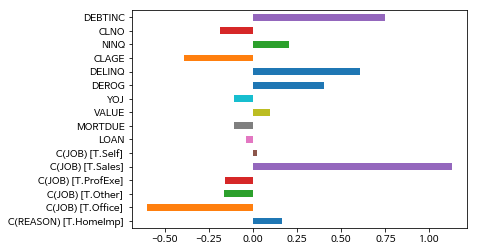

In [22]:
scaled_log_model=sm.Logit.from_formula("""BAD~LOAN+MORTDUE+VALUE+C(REASON)+C(JOB)+YOJ+DEROG+DELINQ+CLAGE+\
                                       NINQ+CLNO+DEBTINC+1""",ds_hmeq_scaled_train)
scaled_log_result=scaled_log_model.fit()
ds_log_scaled_coef=pd.DataFrame({"Coef": scaled_log_result.params.values[1:]},
                               index=scaled_log_model.exog_names[1:])
ds_log_scaled_coef.plot.barh(y="Coef",legend=False)